## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [36]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cpu


In [38]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)    

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

Files already downloaded and verified
Files already downloaded and verified


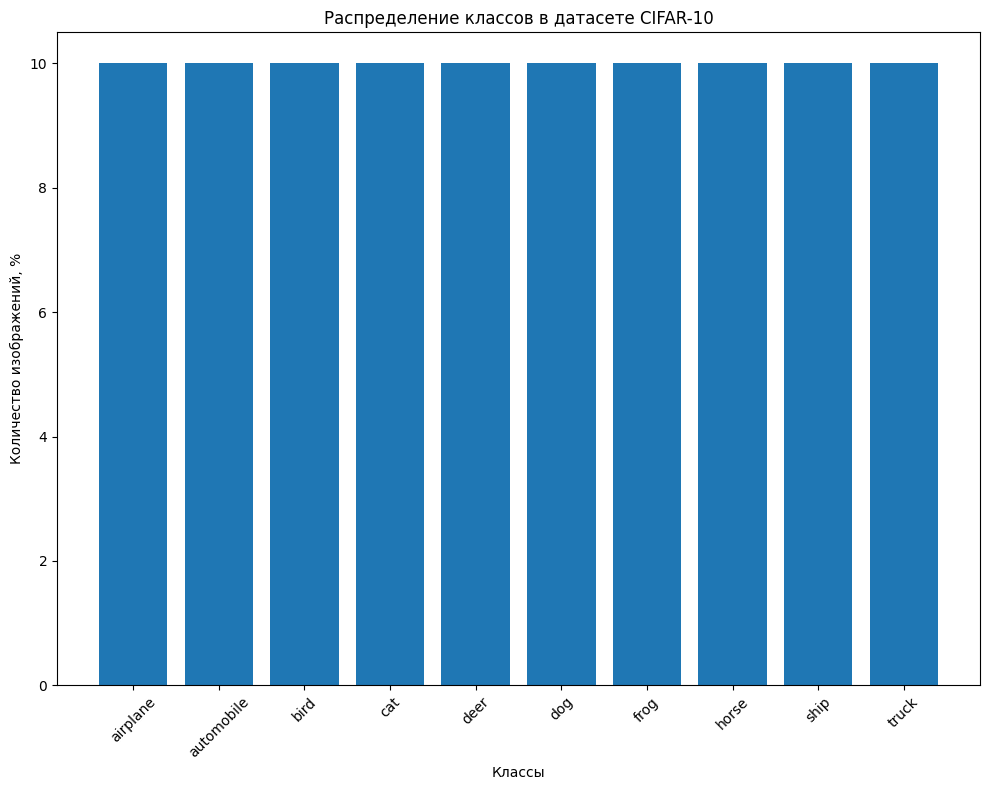

In [39]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Трансформация для тестовых данных
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка датасетов
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.7176471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6784314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.64705884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.36470592].
Clipping input data to the valid rang

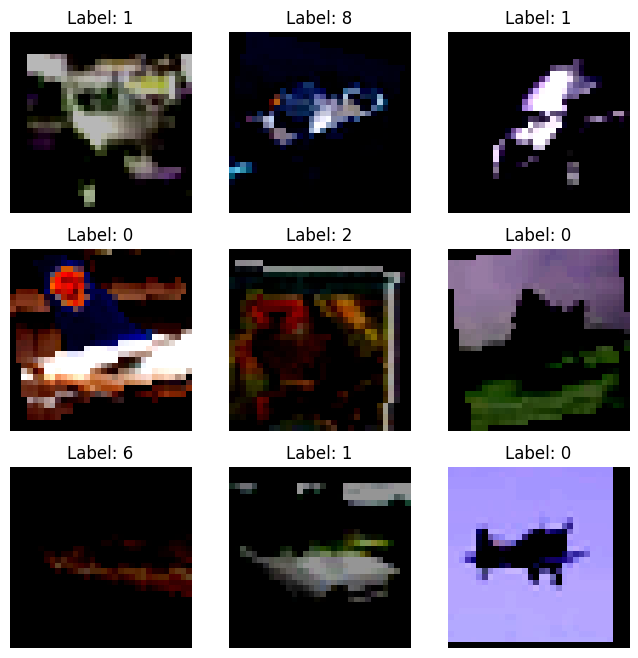

In [40]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Напишем функции train и test

In [41]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    model.train()
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc=f'Train epoch {epoch + 1}/{epochs}')
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': f'{running_loss / (batch_idx + 1):.4f}', 'accuracy': f'{correct / total:.4f}'})
        
        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_correct / val_total)

        scheduler.step()

        print(f'Epoch {epoch + 1}/{epochs} -> Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_correct / val_total:.4f}')
    
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)
    
    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

In [42]:
train_size = int(0.8 * len(train_dataset))  
val_size = len(train_dataset) - train_size  

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [51]:
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Модель
model = CustomCNN(num_classes=10)
print('Model params: ', count_parameters(model))

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Планировщик обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# DataLoader'ы
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  3064586


Обучите модель и постройте графики обучения

In [52]:

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=num_epochs
)


Train epoch 1/50: 100%|█████████████| 625/625 [01:33<00:00,  6.70it/s, loss=1.6966, accuracy=0.3729]


Epoch 1/50 -> Train Loss: 1.6966, Train Acc: 0.3729, Val Loss: 1.2926, Val Acc: 0.5254


Train epoch 2/50: 100%|█████████████| 625/625 [01:42<00:00,  6.11it/s, loss=1.3682, accuracy=0.5045]


Epoch 2/50 -> Train Loss: 1.3682, Train Acc: 0.5045, Val Loss: 1.1419, Val Acc: 0.6020


Train epoch 3/50: 100%|█████████████| 625/625 [01:43<00:00,  6.06it/s, loss=1.1882, accuracy=0.5747]


Epoch 3/50 -> Train Loss: 1.1882, Train Acc: 0.5747, Val Loss: 0.9957, Val Acc: 0.6410


Train epoch 4/50: 100%|█████████████| 625/625 [01:43<00:00,  6.05it/s, loss=1.0784, accuracy=0.6182]


Epoch 4/50 -> Train Loss: 1.0784, Train Acc: 0.6182, Val Loss: 0.9359, Val Acc: 0.6694


Train epoch 5/50: 100%|█████████████| 625/625 [01:43<00:00,  6.05it/s, loss=1.0031, accuracy=0.6439]


Epoch 5/50 -> Train Loss: 1.0031, Train Acc: 0.6439, Val Loss: 0.8311, Val Acc: 0.7116


Train epoch 6/50: 100%|█████████████| 625/625 [01:42<00:00,  6.08it/s, loss=0.9457, accuracy=0.6662]


Epoch 6/50 -> Train Loss: 0.9457, Train Acc: 0.6662, Val Loss: 0.8073, Val Acc: 0.7258


Train epoch 7/50: 100%|█████████████| 625/625 [01:42<00:00,  6.07it/s, loss=0.9001, accuracy=0.6866]


Epoch 7/50 -> Train Loss: 0.9001, Train Acc: 0.6866, Val Loss: 0.7324, Val Acc: 0.7485


Train epoch 8/50: 100%|█████████████| 625/625 [01:43<00:00,  6.07it/s, loss=0.8722, accuracy=0.6941]


Epoch 8/50 -> Train Loss: 0.8722, Train Acc: 0.6941, Val Loss: 0.7453, Val Acc: 0.7390


Train epoch 9/50: 100%|█████████████| 625/625 [01:43<00:00,  6.06it/s, loss=0.8368, accuracy=0.7058]


Epoch 9/50 -> Train Loss: 0.8368, Train Acc: 0.7058, Val Loss: 0.7071, Val Acc: 0.7546


Train epoch 10/50: 100%|████████████| 625/625 [01:45<00:00,  5.95it/s, loss=0.8112, accuracy=0.7154]


Epoch 10/50 -> Train Loss: 0.8112, Train Acc: 0.7154, Val Loss: 0.7207, Val Acc: 0.7578


Train epoch 11/50: 100%|████████████| 625/625 [01:44<00:00,  5.98it/s, loss=0.7235, accuracy=0.7457]


Epoch 11/50 -> Train Loss: 0.7235, Train Acc: 0.7457, Val Loss: 0.6220, Val Acc: 0.7896


Train epoch 12/50: 100%|████████████| 625/625 [01:46<00:00,  5.86it/s, loss=0.7025, accuracy=0.7567]


Epoch 12/50 -> Train Loss: 0.7025, Train Acc: 0.7567, Val Loss: 0.6247, Val Acc: 0.7846


Train epoch 13/50: 100%|████████████| 625/625 [01:46<00:00,  5.88it/s, loss=0.6801, accuracy=0.7616]


Epoch 13/50 -> Train Loss: 0.6801, Train Acc: 0.7616, Val Loss: 0.6063, Val Acc: 0.7964


Train epoch 14/50: 100%|████████████| 625/625 [01:43<00:00,  6.05it/s, loss=0.6649, accuracy=0.7647]


Epoch 14/50 -> Train Loss: 0.6649, Train Acc: 0.7647, Val Loss: 0.5955, Val Acc: 0.7983


Train epoch 15/50: 100%|████████████| 625/625 [01:44<00:00,  5.97it/s, loss=0.6516, accuracy=0.7716]


Epoch 15/50 -> Train Loss: 0.6516, Train Acc: 0.7716, Val Loss: 0.5862, Val Acc: 0.7989


Train epoch 16/50: 100%|████████████| 625/625 [01:59<00:00,  5.25it/s, loss=0.6410, accuracy=0.7735]


Epoch 16/50 -> Train Loss: 0.6410, Train Acc: 0.7735, Val Loss: 0.5895, Val Acc: 0.7993


Train epoch 17/50: 100%|████████████| 625/625 [02:30<00:00,  4.17it/s, loss=0.6254, accuracy=0.7824]


Epoch 17/50 -> Train Loss: 0.6254, Train Acc: 0.7824, Val Loss: 0.5687, Val Acc: 0.8054


Train epoch 18/50: 100%|████████████| 625/625 [01:31<00:00,  6.81it/s, loss=0.6158, accuracy=0.7844]


Epoch 18/50 -> Train Loss: 0.6158, Train Acc: 0.7844, Val Loss: 0.5700, Val Acc: 0.8038


Train epoch 19/50: 100%|████████████| 625/625 [01:37<00:00,  6.42it/s, loss=0.6080, accuracy=0.7854]


Epoch 19/50 -> Train Loss: 0.6080, Train Acc: 0.7854, Val Loss: 0.5682, Val Acc: 0.8055


Train epoch 20/50: 100%|████████████| 625/625 [01:47<00:00,  5.79it/s, loss=0.5965, accuracy=0.7929]


Epoch 20/50 -> Train Loss: 0.5965, Train Acc: 0.7929, Val Loss: 0.5633, Val Acc: 0.8118


Train epoch 21/50: 100%|████████████| 625/625 [01:48<00:00,  5.73it/s, loss=0.5510, accuracy=0.8059]


Epoch 21/50 -> Train Loss: 0.5510, Train Acc: 0.8059, Val Loss: 0.5384, Val Acc: 0.8160


Train epoch 22/50: 100%|████████████| 625/625 [01:43<00:00,  6.06it/s, loss=0.5414, accuracy=0.8096]


Epoch 22/50 -> Train Loss: 0.5414, Train Acc: 0.8096, Val Loss: 0.5193, Val Acc: 0.8239


Train epoch 23/50: 100%|████████████| 625/625 [01:42<00:00,  6.08it/s, loss=0.5369, accuracy=0.8107]


Epoch 23/50 -> Train Loss: 0.5369, Train Acc: 0.8107, Val Loss: 0.5374, Val Acc: 0.8199


Train epoch 24/50: 100%|████████████| 625/625 [01:41<00:00,  6.17it/s, loss=0.5233, accuracy=0.8165]


Epoch 24/50 -> Train Loss: 0.5233, Train Acc: 0.8165, Val Loss: 0.5201, Val Acc: 0.8281


Train epoch 25/50: 100%|████████████| 625/625 [01:42<00:00,  6.12it/s, loss=0.5223, accuracy=0.8172]


Epoch 25/50 -> Train Loss: 0.5223, Train Acc: 0.8172, Val Loss: 0.5201, Val Acc: 0.8274


Train epoch 26/50: 100%|████████████| 625/625 [01:40<00:00,  6.25it/s, loss=0.5059, accuracy=0.8214]


Epoch 26/50 -> Train Loss: 0.5059, Train Acc: 0.8214, Val Loss: 0.5078, Val Acc: 0.8302


Train epoch 27/50: 100%|████████████| 625/625 [01:37<00:00,  6.43it/s, loss=0.5054, accuracy=0.8200]


Epoch 27/50 -> Train Loss: 0.5054, Train Acc: 0.8200, Val Loss: 0.5152, Val Acc: 0.8261


Train epoch 28/50: 100%|████████████| 625/625 [01:37<00:00,  6.41it/s, loss=0.4973, accuracy=0.8252]


Epoch 28/50 -> Train Loss: 0.4973, Train Acc: 0.8252, Val Loss: 0.5080, Val Acc: 0.8283


Train epoch 29/50: 100%|████████████| 625/625 [01:40<00:00,  6.23it/s, loss=0.4931, accuracy=0.8260]


Epoch 29/50 -> Train Loss: 0.4931, Train Acc: 0.8260, Val Loss: 0.5033, Val Acc: 0.8329


Train epoch 30/50: 100%|████████████| 625/625 [01:45<00:00,  5.91it/s, loss=0.4881, accuracy=0.8270]


Epoch 30/50 -> Train Loss: 0.4881, Train Acc: 0.8270, Val Loss: 0.4999, Val Acc: 0.8353


Train epoch 31/50: 100%|████████████| 625/625 [01:45<00:00,  5.92it/s, loss=0.4582, accuracy=0.8379]


Epoch 31/50 -> Train Loss: 0.4582, Train Acc: 0.8379, Val Loss: 0.4918, Val Acc: 0.8379


Train epoch 32/50: 100%|████████████| 625/625 [01:44<00:00,  5.97it/s, loss=0.4496, accuracy=0.8426]


Epoch 32/50 -> Train Loss: 0.4496, Train Acc: 0.8426, Val Loss: 0.4963, Val Acc: 0.8389


Train epoch 33/50: 100%|████████████| 625/625 [01:45<00:00,  5.93it/s, loss=0.4506, accuracy=0.8428]


Epoch 33/50 -> Train Loss: 0.4506, Train Acc: 0.8428, Val Loss: 0.4931, Val Acc: 0.8386


Train epoch 34/50: 100%|████████████| 625/625 [01:45<00:00,  5.93it/s, loss=0.4469, accuracy=0.8416]


Epoch 34/50 -> Train Loss: 0.4469, Train Acc: 0.8416, Val Loss: 0.4889, Val Acc: 0.8409


Train epoch 35/50: 100%|████████████| 625/625 [01:45<00:00,  5.94it/s, loss=0.4366, accuracy=0.8459]


Epoch 35/50 -> Train Loss: 0.4366, Train Acc: 0.8459, Val Loss: 0.4824, Val Acc: 0.8421


Train epoch 36/50: 100%|████████████| 625/625 [01:45<00:00,  5.92it/s, loss=0.4350, accuracy=0.8471]


Epoch 36/50 -> Train Loss: 0.4350, Train Acc: 0.8471, Val Loss: 0.4884, Val Acc: 0.8422


Train epoch 37/50: 100%|████████████| 625/625 [01:45<00:00,  5.91it/s, loss=0.4301, accuracy=0.8488]


Epoch 37/50 -> Train Loss: 0.4301, Train Acc: 0.8488, Val Loss: 0.4806, Val Acc: 0.8407


Train epoch 38/50: 100%|████████████| 625/625 [01:45<00:00,  5.94it/s, loss=0.4330, accuracy=0.8467]


Epoch 38/50 -> Train Loss: 0.4330, Train Acc: 0.8467, Val Loss: 0.4819, Val Acc: 0.8403


Train epoch 39/50: 100%|████████████| 625/625 [01:45<00:00,  5.91it/s, loss=0.4254, accuracy=0.8518]


Epoch 39/50 -> Train Loss: 0.4254, Train Acc: 0.8518, Val Loss: 0.4839, Val Acc: 0.8443


Train epoch 40/50: 100%|████████████| 625/625 [01:46<00:00,  5.88it/s, loss=0.4223, accuracy=0.8514]


Epoch 40/50 -> Train Loss: 0.4223, Train Acc: 0.8514, Val Loss: 0.4870, Val Acc: 0.8395


Train epoch 41/50: 100%|████████████| 625/625 [01:45<00:00,  5.93it/s, loss=0.4079, accuracy=0.8563]


Epoch 41/50 -> Train Loss: 0.4079, Train Acc: 0.8563, Val Loss: 0.4683, Val Acc: 0.8466


Train epoch 42/50: 100%|████████████| 625/625 [01:46<00:00,  5.88it/s, loss=0.4103, accuracy=0.8536]


Epoch 42/50 -> Train Loss: 0.4103, Train Acc: 0.8536, Val Loss: 0.4785, Val Acc: 0.8437


Train epoch 43/50: 100%|████████████| 625/625 [01:48<00:00,  5.75it/s, loss=0.3986, accuracy=0.8588]


Epoch 43/50 -> Train Loss: 0.3986, Train Acc: 0.8588, Val Loss: 0.4770, Val Acc: 0.8437


Train epoch 44/50: 100%|████████████| 625/625 [01:48<00:00,  5.75it/s, loss=0.3987, accuracy=0.8593]


Epoch 44/50 -> Train Loss: 0.3987, Train Acc: 0.8593, Val Loss: 0.4752, Val Acc: 0.8455


Train epoch 45/50: 100%|████████████| 625/625 [01:43<00:00,  6.06it/s, loss=0.3998, accuracy=0.8586]


Epoch 45/50 -> Train Loss: 0.3998, Train Acc: 0.8586, Val Loss: 0.4688, Val Acc: 0.8491


Train epoch 46/50: 100%|████████████| 625/625 [01:54<00:00,  5.45it/s, loss=0.3976, accuracy=0.8599]


Epoch 46/50 -> Train Loss: 0.3976, Train Acc: 0.8599, Val Loss: 0.4716, Val Acc: 0.8477


Train epoch 47/50: 100%|████████████| 625/625 [01:39<00:00,  6.29it/s, loss=0.3941, accuracy=0.8600]


Epoch 47/50 -> Train Loss: 0.3941, Train Acc: 0.8600, Val Loss: 0.4751, Val Acc: 0.8445


Train epoch 48/50: 100%|████████████| 625/625 [01:28<00:00,  7.02it/s, loss=0.3941, accuracy=0.8591]


Epoch 48/50 -> Train Loss: 0.3941, Train Acc: 0.8591, Val Loss: 0.4857, Val Acc: 0.8434


Train epoch 49/50: 100%|████████████| 625/625 [01:27<00:00,  7.10it/s, loss=0.3893, accuracy=0.8620]


Epoch 49/50 -> Train Loss: 0.3893, Train Acc: 0.8620, Val Loss: 0.4742, Val Acc: 0.8451


Train epoch 50/50: 100%|████████████| 625/625 [01:43<00:00,  6.06it/s, loss=0.3854, accuracy=0.8638]


Epoch 50/50 -> Train Loss: 0.3854, Train Acc: 0.8638, Val Loss: 0.4742, Val Acc: 0.8452


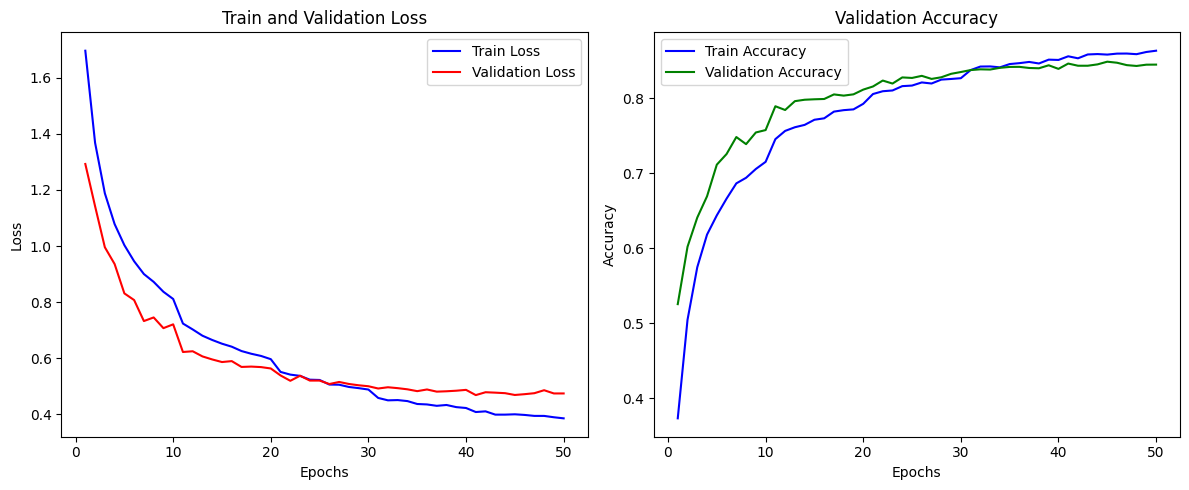

In [53]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [54]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.4742
Test Accuracy: 0.8452


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов